In [3]:
import nibabel as nib
import numpy as np

In [4]:
class Namespace:
    """
    a class generate parser for cmd line args
    """
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [5]:
"""
packages that generate train/test dataset
"""
from FormatData import generate_data, parser as data_parser

In [6]:
"""
packages that trains network
"""
from Training import train_network
from utils.model import parser as model_parser

In [7]:
"""
packages that test network
"""
from Testing import test_model

In [8]:
"""
packages that handle graphs
"""
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from skimage.metrics import structural_similarity as compare_ssim
from utils import calc_ssim
%matplotlib inline
def plot_loss(cmd):
    """
    A function that used to plot the loss curve for the trained network.
    Args:
        cmd: String, the command line in the terminal
    """
    args = model_parser().parse_args(cmd.split())
    history = train_network(args)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def show_slices(slices, grayscale=True):
    """
    Function to display the slices

    Args:
        slices (list): a list of 2d ndarray that contains the data to be displayed
        grayscale (bool, optional): True, if diplay grayscale img. Defaults to True.
    """    
    # define the colormap
    cmap = plt.get_cmap('seismic')

    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

    fig, axes = plt.subplots(1, len(slices), figsize=(10,10))
    cax = fig.add_axes([0, 0, .3, .3])
    for i, slice in enumerate(slices):
        # use grayscale for displaying ref and pred imgs:
        if grayscale:
            im = axes[i].imshow(slice.T, cmap='gray', origin="lower", interpolation='none')
        else:
            # define the bins and normalize and forcing 0 to be part of the colorbar
            # define the min and max to be -1 and +1 respectively
            bounds = np.arange(-1, +1, .01)
            idx = np.searchsorted(bounds, 0)
            bounds = np.insert(bounds, idx, 0)
            norm = BoundaryNorm(bounds, cmap.N)
            im = axes[i].imshow(slice.T, cmap=cmap, origin="lower", interpolation='none', norm=norm)
        fig.colorbar(im, cax=cax, orientation='vertical')

def scale(img):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img[i][j] = ((img[i][j]+1)/2)*255
    return img

def compare_simi(pred, ref):
    return calc_ssim(pred, ref)

In [9]:
# A simple test to verify the algorithm mask_nii_data from utils.nii_utils correctly generates the 1x1 patch from (a) given volume(s) DWI
from utils.nii_utils import mask_nii_data
s02_mask_path = '../Net/datasets/mask/mask_s02_still.nii'
s02_mask_data = nib.load(s02_mask_path).get_fdata()
print(s02_mask_data.shape)
# generate a random mask
random_mask = np.zeros((s02_mask_data.shape[0],s02_mask_data.shape[1], s02_mask_data.shape[2]))
print(random_mask.shape)
# select some pixels' values in the random_mask turn into 1
# randomly select 4 paris of x, y value
for i in range(4):
    rand_x = np.random.randint(low=0, high=s02_mask_data.shape[0])
    rand_y = np.random.randint(low=0, high=s02_mask_data.shape[1])
    rand_z = np.random.randint(low=0, high=s02_mask_data.shape[2])
    # set the corresponding pixel to have value 1
    random_mask[rand_x][rand_y][rand_z] = 1
# by this, we know the ground truth for this test. The number of 1s in the mask = the number of 1x1 pacth generated from the algorithm
# we apply the random mask onto the s02_mask
data = mask_nii_data(data=s02_mask_data, mask=random_mask)

(84, 84, 50)
(84, 84, 50)
mask has shape: (352800,)
data befor masking has shape: (352800, 1)
data after masking has shape: (4, 1) the ratio of masked voxel is: 1.1337868480725624e-05


<strong>Interpret the result from the algorithm test.</strong>
The s02_mask has only one volume of shape (84,84,50). The random mask has a shape (84,84,50).</br>
We randomly turned 4 pixels in the random mask to 1. Then apply the random mask to the s02_mask.</br>
<strong>What we expect to see, there should be 4 patches generated for each volume of s02_mask.</strong></br>
Results show that the data afer masking (by the random mask) has a shape (4,1). Where 4 represents the number of 1x1 patches and 1 represent the volume of s02_mask.</br>
Therefore, it suggests the algorithm works fine.

(10332, 3, 3, 96)
(10332, 3, 3, 96)


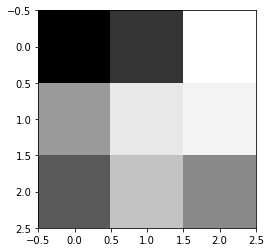

In [22]:
# generate a 2d patch
from utils.data_utils import gen_2d_patches
mask = nib.load('../Net/datasets/mask/mask_s01_still.nii')
data = nib.load('/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s01_still/diffusion.nii')
mask = np.array(mask.dataobj)
data = np.array(data.dataobj)
data = data / data.mean() - 1.0

base = 1
patch_size = 3
label_size = 3
mask = mask[base:-base, base:-base, base:-base]
data = data[:, :, base:-base, :]

pacthes = gen_2d_patches(data, mask, patch_size, label_size)
print(pacthes.shape)
plt.imshow(pacthes[9,:,:,0], cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(84, 84, 48, 96) (82, 82, 48)
(3640, 3, 3, 3, 96)
(3640, 3, 3, 3, 96)


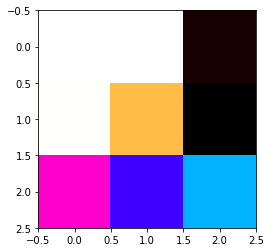

In [11]:
# generate a 3d patch
from utils.data_utils import gen_3d_patches
mask = nib.load('../Net/datasets/mask/mask_s01_still.nii')
data = nib.load('/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s01_still/diffusion.nii')
mask = np.array(mask.dataobj)
data = np.array(data.dataobj)
data = data / data.mean() - 1.0

base = 1
patch_size = 3
label_size = 3
mask = mask[base:-base, base:-base, base:-base]
data = data[:, :, base:-base, :]

pacthes = gen_3d_patches(data, mask, patch_size, label_size)
print(pacthes.shape)
plt.imshow(pacthes[0,:,:,:,0], cmap='gray')

_______

<h3>Experiment 1. Discover the number of hidden acquired to produce promising each NODDI measure.</h3>

___

<h4>Test NDI</h4>
<strong>Training subject: s01_still<br/>

Test subject: s02_still<br/>

Outcome: NDI<br/></strong>


<h4>Data Preprocessing</h4>

In [ ]:
"""
Generate the base dataset for s01_still and s02_still first.
"""
cmd = "--base --label_type N --subjects s01_still s02_still"
args = data_parser().parse_args(cmd.split())
generate_data(args)

<strong>Interpret the result. </strong><br/>
The base dataset for s01_still and s02_still has the same shape.<br/>
The data has shape (84, 84, 50, 96); where (84, 84, 50) is the width, height and slice of each volume of DWI; where 96 is the volume of DWI<br/>
The label has shape (84, 84, 50, 1); where (84, 84, 50) is the width, height and slice of each volume of label; where 1 is the volume of label (because we are predicting NDI only in this case)


In [ ]:
"""
Generate training dataset NDI for ANN.
"""
cmd = "--subjects s01_still --fc1d --label_type N"
args = data_parser().parse_args(cmd.split())
generate_data(args)

<strong>
Interpret this result.
</strong> 
After the mask is applied to 96 volumes of DWI imgs, for each volume of img, there are 82889 1x1 patches (i.e. voxels) generated. Therefore, in total there are 82889x96=7957344 values as training dataset. <br/>
For each masked voxel, there is a corresponding NDI value. Therefore, the number of NDI values is the same as the number of masked voxels (82889). Becasue we are examine NDI only, hence only one value associated with each masked voxel.

<img src="/home/vw/Desktop/IndividualProject/Graphs/ANN Graphs/ANN Data Preprocessing.png" width="800" height="400">

In [ ]:
# Generate the dataset for 2D CNN
cmd = "--subjects s01_still --conv2d --label_type N"
args = data_parser().parse_args(cmd.split())
generate_data(args)

<strong>
Interpret the result
</strong>
The masked voxels are 82641. For each masked voxel, there is a 3x3 patch which includes this masked voxel at the centre of the patch; but also including its 8 neighbouring voxels. Each masked voxel has 96 volumes of the 3x3 patch. Therefore, in total there are 82641 x 3 x 3 x 96 = 71401824 values as the training dataset.<br/>
Herein, because we only examine NDI. For each masked voxel, there is a corresponded predicted NDI value. Hence the number of masked voxels is the same for label and data. The label size is 1x1 because it is the NDI parameter for the masked voxel. The masked voxel has a size 1x1. And there is only one of this value for each masked voxel, since only NDI is considered.

<img src="/home/vw/Desktop/IndividualProject/Graphs/2D CNN graphs/2D CNN Data Preprocessing.png" width="800" height="400">

In [ ]:
# Generate the dataset for 3D CNN
cmd = "--subjects s01_still --conv3d --label_type N"
args = data_parser().parse_args(cmd.split())
generate_data(args)

<strong>
Interpret the result
</strong>
The masked voxels are 82641. For each masked voxel, there is a 3x3x3 patch which includes this masked voxel at the centre of the patch; but also including its 26 neighbouring voxels. Each masked voxel has 96 volumes of 3x3x3 patch. Therefore, in total there are 82641 x 3 x 3 x 3 x 96 = 214205472 values as the training dataset.<br/>
Herein, because we only examine NDI. For each masked voxel, there is a corresponded predicted NDI value. Hence the number of masked voxels is the same for label and data. The label size is 1x1x1 because it is the NDI parameter for the masked voxel. The masked voxel has a size 1x1x1. And there is only one of this value for each masked voxel, since only NDI is considered.

In [13]:
"""
Using nib to fetch the ground truth img
"""
s02_NDI_path = '../Data-NODDI/s02_still/s02_still_NDI.nii'
s02_mask_path = '../Net/datasets/mask/mask_s02_still.nii'
s02_NDI_img = nib.load(s02_NDI_path)
s02_NDI_img_data = s02_NDI_img.get_fdata()
s02_mask_img = nib.load(s02_mask_path)
s02_mask_img_data = s02_mask_img.get_fdata()

<h4>Training</h4>

<strong>
The split between validation dataset and the training dataset is 5:5<br/>
The learning rate is 0.0001 to ensure a smooth learning<br/>
Herein, at most 6 hidden fully connected layers are trained.<br/>
Loss curve for each training is plotted.<br/>
The test result is also generated -- evaluating the RMSE and SSIM between pred and reference.<br/>
The reference image and the genereated image are displayed side by side.</br>
The difference map between the ref img and the pred img is also generated
</strong>

<strong>1 layer</strong>

ANN

In [ ]:
# 1 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 1 --train --label_type N"
plot_loss(cmd)

<img src="/home/vw/Desktop/IndividualProject/Graphs/ANN Graphs/ANN Input Layer.png" width="800" height="400">

To verify this, the output shape from the Input layer is [(None, 96)]. Since we are using 96 DWI images as input size. Therefore, it is true that the graph shows the correct thing. The output from the Input layer is N number of masked voxel. Each voxel has size (1,1). Therefore, in total 96 values

<img src="/home/vw/Desktop/IndividualProject/Graphs/ANN Graphs/ANN FC Layer.png" width="800" height="400">

To verify this, the output shape after the first dense layer is (None, 150). Where 150 is the output dimenstion chosen for the model. Also, to verify the number of trained parameters. In this case N=96, M=150; the number of trained parameters are (96+1)x150=14550.

<img src="/home/vw/Desktop/IndividualProject/Graphs/Dropout Layer.png" width="800" height="400">

There are no parameter trained at this layer

<img src="/home/vw/Desktop/IndividualProject/Graphs/Output Layer.png" width="800" height="400">

In this case, we only have one neuron at the output layer. Becasue we are examing the network performance on deriving NDI. Therefore, the output shape is (1x1) patch, i.e. the NDI value of the chosen voxel. To verify the number of parameters trained, M=150 and output dimension is 1. So (150+1)x1=151 trained parameters

In [ ]:
# 1 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 1 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 1 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 1 --train --label_type N"
plot_loss(cmd)

<img src="/home/vw/Desktop/IndividualProject/Graphs/2D CNN graphs/2D CNN Input Layer.png" width="800" height="400">

To verify this, the output shape from the Input layer is [(None, 3, 3, 96)]. Since we are using 96 DWI images as input size. Therefore, it is true that the graph shows the correct thing. The output from the Input layer is N number of 3x3 patches contains the masked voxel at the centre and it neighbouring 8 voxels. Each voxel has size (1,1), suggest the information at this voxel.

<img src="/home/vw/Desktop/IndividualProject/Graphs/2D CNN graphs/2D CNN Conv Layer.png" width="800" height="400">

To verify this, the output shape after the first dense layer is (None, 1, 1, 150). Where 150 is the output dimenstion chosen for the model. Also, to verify the number of trained parameters. In this case N=96, M=150; the number of trained parameters are (3x3x96+1)x150=129750.

<img src="/home/vw/Desktop/IndividualProject/Graphs/Dropout Layer.png" width="800" height="400">

<img src="/home/vw/Desktop/IndividualProject/Graphs/2D CNN graphs/2D CNN Output Layer.png" width="800" height="400">

In this case, we only have one neuron at the output layer. Becasue we are examing the network performance on deriving NDI. Therefore, the output shape is (1x1) patch, i.e. the NDI value of the central masked voxel. To verify the number of parameters trained, M=150 and output dimension is 1. So (150+1)x1=151 trained parameters

In [ ]:
# 1 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 1 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 1 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 1 --train --label_type N"
plot_loss(cmd)

In [ ]:
# 1 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 1 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

the ssim score for ann is: 0.9782066766684739
SSIM: 0.9824161559292238
the ssim score for 2d cnn is: 0.9544394165059871
SSIM: 0.9688503106364653
the ssim score for 3d cnn is: 0.9393416550093304
SSIM: 0.9580557873062248


Text(0.5, 0.98, 'Difference map 3D CNN')

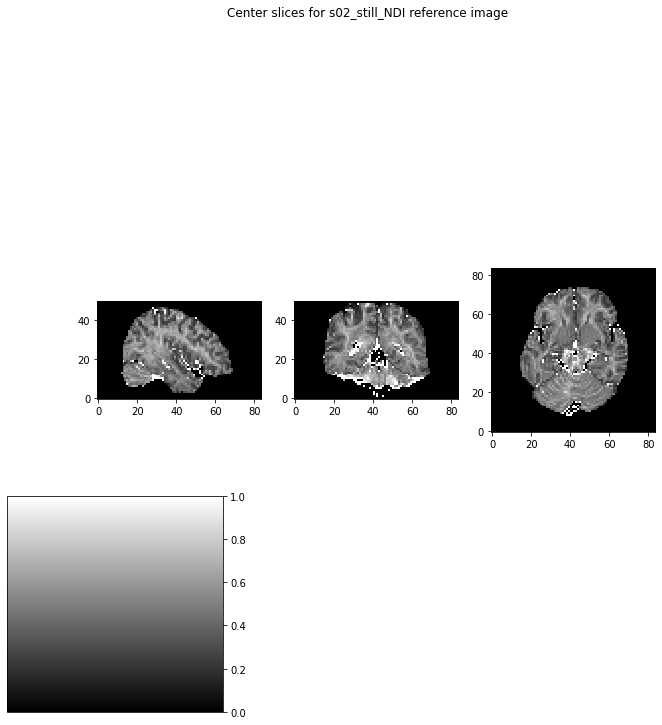

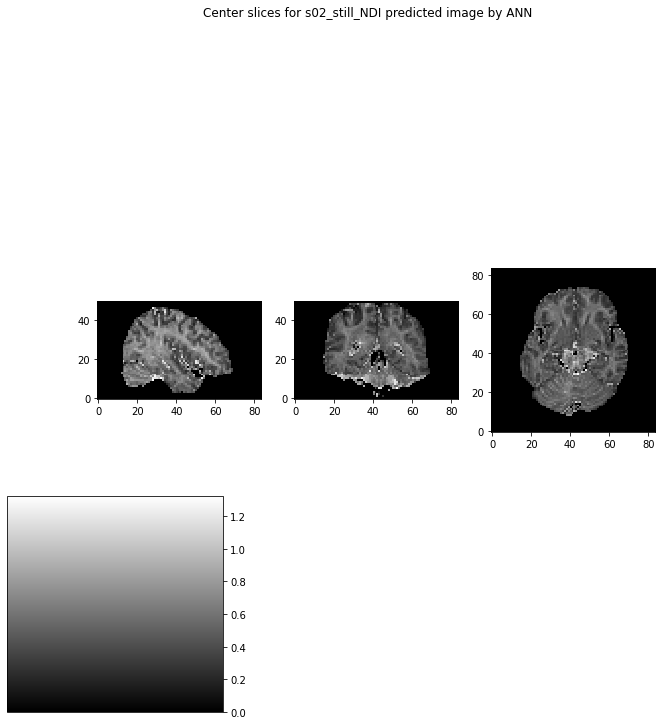

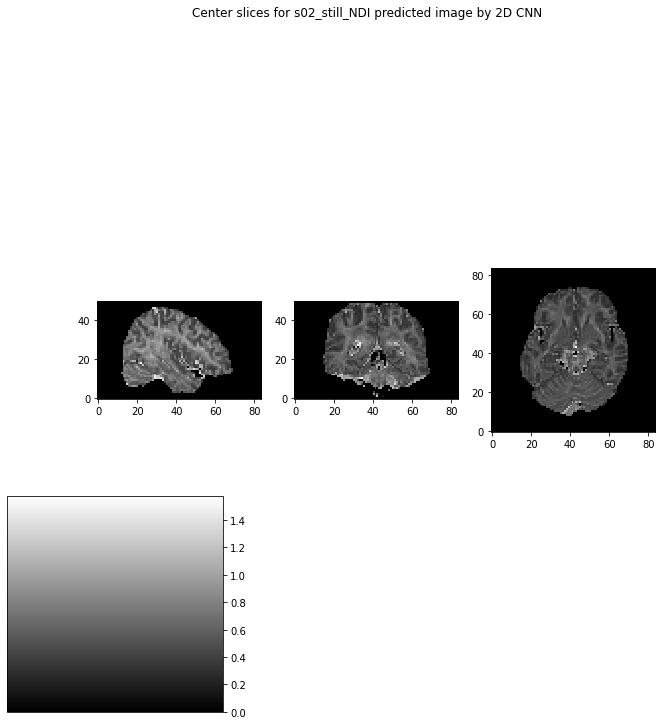

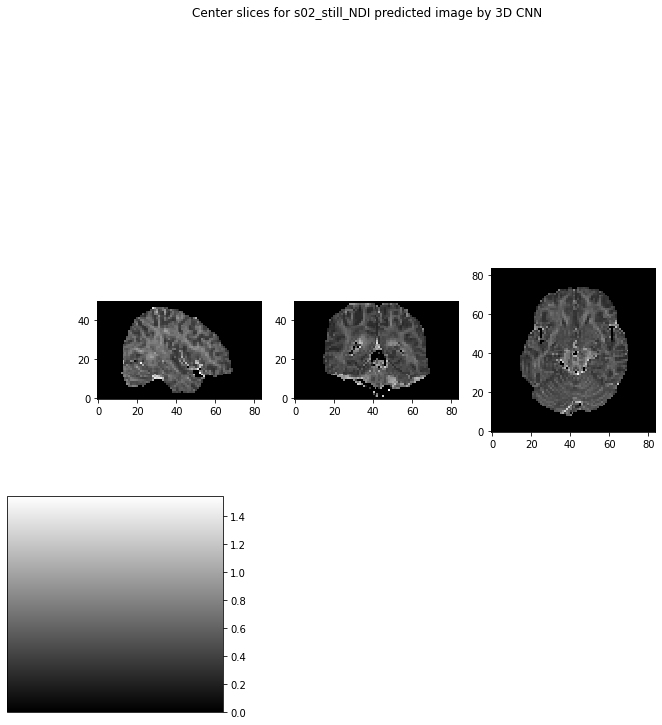

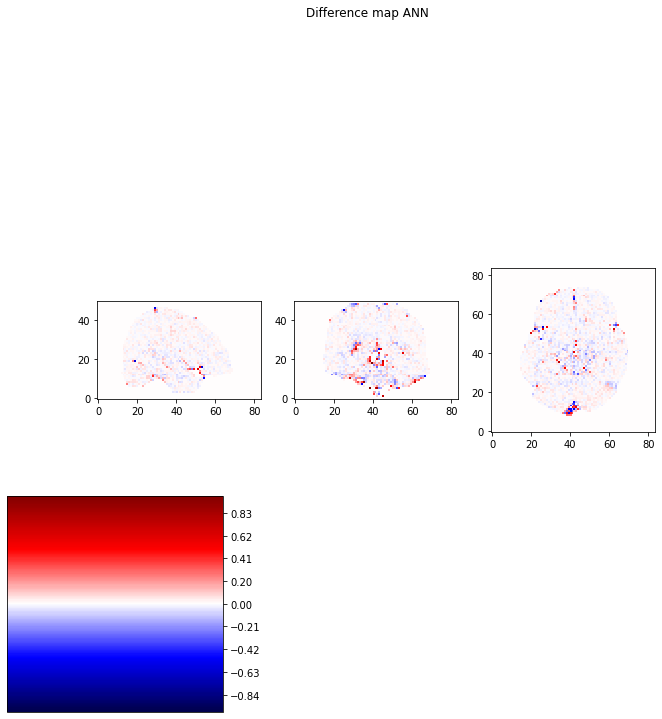

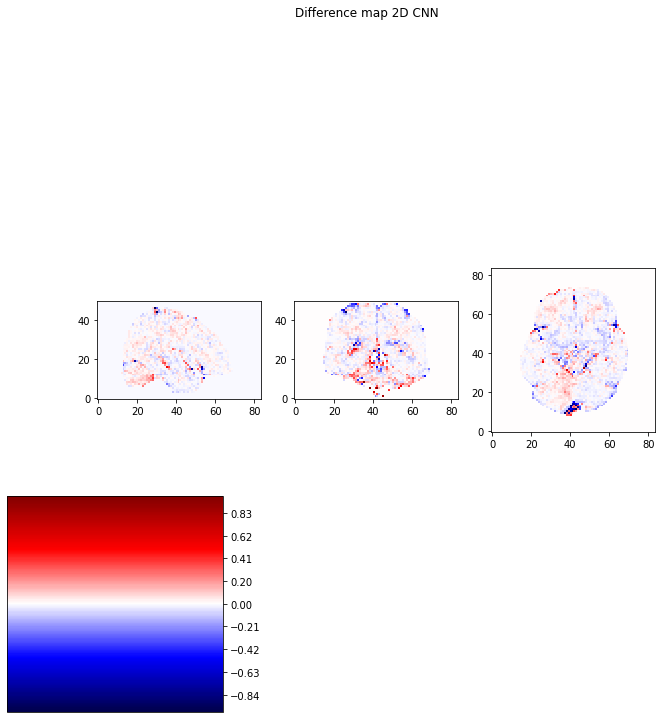

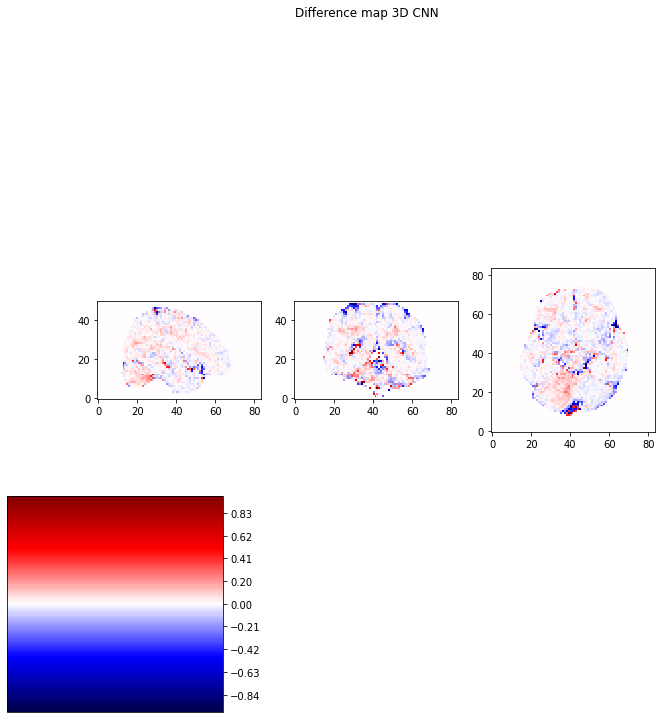

In [14]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-NDI-96-fc1d-patch_1-base_1-layer_1.nii'
cnn2d_path = '../Net/nii/s02_still-NDI-96-conv2d-patch_3-base_1-layer_1.nii'
cnn3d_path = '../Net/nii/s02_still-NDI-96-conv3d-patch_3-base_1-layer_1.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_NDI_img_data[26, :, :]
ref_slice_1 = s02_NDI_img_data[:, 30, :]
ref_slice_2 = s02_NDI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_NDI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_NDI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))


cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))


cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))


# plot the difference map
anndiff0 = ref_slice_0 - ann0
anndiff1 = ref_slice_1 - ann1
anndiff2 = ref_slice_2 - ann2
show_slices([anndiff0, anndiff1, anndiff2], grayscale=False)
plt.suptitle("Difference map ANN")

cnn2ddiff0 = ref_slice_0 - cnn2d0
cnn2ddiff1 = ref_slice_1 - cnn2d1
cnn2ddiff2 = ref_slice_2 - cnn2d2
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2], grayscale=False)
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = ref_slice_0 - cnn3d0
cnn3ddiff1 = ref_slice_1 - cnn3d1
cnn3ddiff2 = ref_slice_2 - cnn3d2
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2], grayscale=False)
plt.suptitle("Difference map 3D CNN")

<strong>2 layer</strong>

ANN

In [ ]:
# 2 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 2 --train --label_type N"
plot_loss(cmd)
# 2 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 2 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 2 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 2 --train --label_type N"
plot_loss(cmd)
# 2 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 2 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 2 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 2 --train --label_type N"
plot_loss(cmd)
# 2 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 2 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-NDI-96-fc1d-patch_1-base_1-layer_2.nii'
cnn2d_path = '../Net/nii/s02_still-NDI-96-conv2d-patch_3-base_1-layer_2.nii'
cnn3d_path = '../Net/nii/s02_still-NDI-96-conv3d-patch_3-base_1-layer_2.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_NDI_img_data[26, :, :]
ref_slice_1 = s02_NDI_img_data[:, 30, :]
ref_slice_2 = s02_NDI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_NDI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_NDI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map
anndiff0 = ref_slice_0 - ann0
anndiff1 = ref_slice_1 - ann1
anndiff2 = ref_slice_2 - ann2
show_slices([anndiff0, anndiff1, anndiff2], grayscale=False)
plt.suptitle("Difference map ANN")

cnn2ddiff0 = ref_slice_0 - cnn2d0
cnn2ddiff1 = ref_slice_1 - cnn2d1
cnn2ddiff2 = ref_slice_2 - cnn2d2
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2], grayscale=False)
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = ref_slice_0 - cnn3d0
cnn3ddiff1 = ref_slice_1 - cnn3d1
cnn3ddiff2 = ref_slice_2 - cnn3d2
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2], grayscale=False)
plt.suptitle("Difference map 3D CNN")

<strong>3 layer</strong>

ANN

In [ ]:
# 3 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 3 --train --label_type N"
plot_loss(cmd)
# 2 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 3 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 3 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 3 --train --label_type N"
plot_loss(cmd)
# 3 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 3 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 3 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 3 --train --label_type N"
plot_loss(cmd)
# 3 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 3 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-NDI-96-fc1d-patch_1-base_1-layer_3.nii'
cnn2d_path = '../Net/nii/s02_still-NDI-96-conv2d-patch_3-base_1-layer_3.nii'
cnn3d_path = '../Net/nii/s02_still-NDI-96-conv3d-patch_3-base_1-layer_3.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_NDI_img_data[26, :, :]
ref_slice_1 = s02_NDI_img_data[:, 30, :]
ref_slice_2 = s02_NDI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_NDI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_NDI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map
anndiff0 = ref_slice_0 - ann0
anndiff1 = ref_slice_1 - ann1
anndiff2 = ref_slice_2 - ann2
show_slices([anndiff0, anndiff1, anndiff2], grayscale=False)
plt.suptitle("Difference map ANN")

cnn2ddiff0 = ref_slice_0 - cnn2d0
cnn2ddiff1 = ref_slice_1 - cnn2d1
cnn2ddiff2 = ref_slice_2 - cnn2d2
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2], grayscale=False)
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = ref_slice_0 - cnn3d0
cnn3ddiff1 = ref_slice_1 - cnn3d1
cnn3ddiff2 = ref_slice_2 - cnn3d2
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2], grayscale=False)
plt.suptitle("Difference map 3D CNN")

<strong>4 layer</strong>

ANN

In [ ]:
# 4 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 4 --train --label_type N"
plot_loss(cmd)
# 4 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 4 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 4 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 4 --train --label_type N"
plot_loss(cmd)
# 4 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 4 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 4 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 4 --train --label_type N"
plot_loss(cmd)
# 4 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 4 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-NDI-96-fc1d-patch_1-base_1-layer_4.nii'
cnn2d_path = '../Net/nii/s02_still-NDI-96-conv2d-patch_3-base_1-layer_4.nii'
cnn3d_path = '../Net/nii/s02_still-NDI-96-conv3d-patch_3-base_1-layer_4.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_NDI_img_data[26, :, :]
ref_slice_1 = s02_NDI_img_data[:, 30, :]
ref_slice_2 = s02_NDI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_NDI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_NDI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map
anndiff0 = ref_slice_0 - ann0
anndiff1 = ref_slice_1 - ann1
anndiff2 = ref_slice_2 - ann2
show_slices([anndiff0, anndiff1, anndiff2], grayscale=False)
plt.suptitle("Difference map ANN")

cnn2ddiff0 = ref_slice_0 - cnn2d0
cnn2ddiff1 = ref_slice_1 - cnn2d1
cnn2ddiff2 = ref_slice_2 - cnn2d2
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2], grayscale=False)
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = ref_slice_0 - cnn3d0
cnn3ddiff1 = ref_slice_1 - cnn3d1
cnn3ddiff2 = ref_slice_2 - cnn3d2
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2], grayscale=False)
plt.suptitle("Difference map 3D CNN")

<strong>5 layer</strong>

ANN

In [ ]:
# 5 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 5 --train --label_type N"
plot_loss(cmd)
# 5 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 5 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 5 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 5 --train --label_type N"
plot_loss(cmd)
# 5 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 5 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 5 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 5 --train --label_type N"
plot_loss(cmd)
# 5 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 5 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-NDI-96-fc1d-patch_1-base_1-layer_5.nii'
cnn2d_path = '../Net/nii/s02_still-NDI-96-conv2d-patch_3-base_1-layer_5.nii'
cnn3d_path = '../Net/nii/s02_still-NDI-96-conv3d-patch_3-base_1-layer_5.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_NDI_img_data[26, :, :]
ref_slice_1 = s02_NDI_img_data[:, 30, :]
ref_slice_2 = s02_NDI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_NDI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_NDI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map
anndiff0 = ref_slice_0 - ann0
anndiff1 = ref_slice_1 - ann1
anndiff2 = ref_slice_2 - ann2
show_slices([anndiff0, anndiff1, anndiff2], grayscale=False)
plt.suptitle("Difference map ANN")

cnn2ddiff0 = ref_slice_0 - cnn2d0
cnn2ddiff1 = ref_slice_1 - cnn2d1
cnn2ddiff2 = ref_slice_2 - cnn2d2
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2], grayscale=False)
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = ref_slice_0 - cnn3d0
cnn3ddiff1 = ref_slice_1 - cnn3d1
cnn3ddiff2 = ref_slice_2 - cnn3d2
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2], grayscale=False)
plt.suptitle("Difference map 3D CNN")

<strong>6 layer</strong>

ANN

In [ ]:
# 6 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 6 --train --label_type N"
plot_loss(cmd)
# 6 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 6 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 6 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 6 --train --label_type N"
plot_loss(cmd)
# 6 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 6 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 6 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 6 --train --label_type N"
plot_loss(cmd)
# 6 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 6 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-NDI-96-fc1d-patch_1-base_1-layer_6.nii'
cnn2d_path = '../Net/nii/s02_still-NDI-96-conv2d-patch_3-base_1-layer_6.nii'
cnn3d_path = '../Net/nii/s02_still-NDI-96-conv3d-patch_3-base_1-layer_6.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_NDI_img_data[26, :, :]
ref_slice_1 = s02_NDI_img_data[:, 30, :]
ref_slice_2 = s02_NDI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_NDI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_NDI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map
anndiff0 = ref_slice_0 - ann0
anndiff1 = ref_slice_1 - ann1
anndiff2 = ref_slice_2 - ann2
show_slices([anndiff0, anndiff1, anndiff2], grayscale=False)
plt.suptitle("Difference map ANN")

cnn2ddiff0 = ref_slice_0 - cnn2d0
cnn2ddiff1 = ref_slice_1 - cnn2d1
cnn2ddiff2 = ref_slice_2 - cnn2d2
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2], grayscale=False)
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = ref_slice_0 - cnn3d0
cnn3ddiff1 = ref_slice_1 - cnn3d1
cnn3ddiff2 = ref_slice_2 - cnn3d2
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2], grayscale=False)
plt.suptitle("Difference map 3D CNN")

___

Training subject: s01_still</br>
Test subject: s02_still</br>
Outcome: ODI</br>


<h4>Data Preprocessing</h4>

In [ ]:
"""
Generate the base dataset for s01_still and s02_still first.
"""
cmd = "--base --label_type O --subjects s01_still s02_still"
args = data_parser().parse_args(cmd.split())
generate_data(args)

In [ ]:
"""
Generate training dataset ODI for ANN.
"""
cmd = "--subjects s01_still --fc1d --label_type O"
args = data_parser().parse_args(cmd.split())
generate_data(args)

In [ ]:
"""
Generate training dataset ODI for 2D CNN.
"""
cmd = "--subjects s01_still --conv2d --label_type O"
args = data_parser().parse_args(cmd.split())
generate_data(args)

In [ ]:
"""
Generate training dataset ODI for 3D CNN.
"""
cmd = "--subjects s01_still --conv3d --label_type O"
args = data_parser().parse_args(cmd.split())
generate_data(args)

In [15]:
"""
Using nib to fetch the  data, used for evaluation
"""
s02_ODI_path = '../Data-NODDI/s02_still/s02_still_ODI.nii'
s02_mask_path = '../Net/datasets/mask/mask_s02_still.nii'
s02_ODI_img = nib.load(s02_ODI_path)
s02_ODI_img_data = s02_ODI_img.get_fdata()
s02_mask_img = nib.load(s02_mask_path)
s02_mask_img_data = s02_mask_img.get_fdata()

<strong>1 layer</strong>

ANN

In [ ]:
# 1 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 1 --train --label_type O"
plot_loss(cmd)
# 1 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 1 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 1 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 1 --train --label_type O"
plot_loss(cmd)
# 1 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 1 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 1 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 1 --train --label_type O"
plot_loss(cmd)
# 1 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 1 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-ODI-96-fc1d-patch_1-base_1-layer_1.nii'
cnn2d_path = '../Net/nii/s02_still-ODI-96-conv2d-patch_3-base_1-layer_1.nii'
cnn3d_path = '../Net/nii/s02_still-ODI-96-conv3d-patch_3-base_1-layer_1.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_ODI_img_data[26, :, :]
ref_slice_1 = s02_ODI_img_data[:, 30, :]
ref_slice_2 = s02_ODI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_ODI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_ODI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_ODI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))


cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_ODI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_ODI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map
anndiff0 = ref_slice_0 - ann0
anndiff1 = ref_slice_1 - ann1
anndiff2 = ref_slice_2 - ann2
show_slices([anndiff0, anndiff1, anndiff2], grayscale=False)
plt.suptitle("Difference map ANN")

cnn2ddiff0 = ref_slice_0 - cnn2d0
cnn2ddiff1 = ref_slice_1 - cnn2d1
cnn2ddiff2 = ref_slice_2 - cnn2d2
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2], grayscale=False)
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = ref_slice_0 - cnn3d0
cnn3ddiff1 = ref_slice_1 - cnn3d1
cnn3ddiff2 = ref_slice_2 - cnn3d2
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2], grayscale=False)
plt.suptitle("Difference map 3D CNN")

<strong>2 layer</strong>

ANN

In [ ]:
# 2 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 2 --train --label_type O"
plot_loss(cmd)
# 2 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 2 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 2 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 2 --train --label_type O"
plot_loss(cmd)
# 2 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 2 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 2 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 2 --train --label_type O"
plot_loss(cmd)
# 2 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 2 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-ODI-96-fc1d-patch_1-base_1-layer_2.nii'
cnn2d_path = '../Net/nii/s02_still-ODI-96-conv2d-patch_3-base_1-layer_2.nii'
cnn3d_path = '../Net/nii/s02_still-ODI-96-conv3d-patch_3-base_1-layer_2.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_ODI_img_data[26, :, :]
ref_slice_1 = s02_ODI_img_data[:, 30, :]
ref_slice_2 = s02_ODI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_ODI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_ODI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_ODI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_ODI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_ODI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map
anndiff0 = ref_slice_0 - ann0
anndiff1 = ref_slice_1 - ann1
anndiff2 = ref_slice_2 - ann2
show_slices([anndiff0, anndiff1, anndiff2], grayscale=False)
plt.suptitle("Difference map ANN")

cnn2ddiff0 = ref_slice_0 - cnn2d0
cnn2ddiff1 = ref_slice_1 - cnn2d1
cnn2ddiff2 = ref_slice_2 - cnn2d2
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2], grayscale=False)
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = ref_slice_0 - cnn3d0
cnn3ddiff1 = ref_slice_1 - cnn3d1
cnn3ddiff2 = ref_slice_2 - cnn3d2
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2], grayscale=False)
plt.suptitle("Difference map 3D CNN")

<strong>3 layer</strong>

ANN

In [ ]:
# 3 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 3 --train --label_type O"
plot_loss(cmd)
# 3 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 3 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 3 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 3 --train --label_type O"
plot_loss(cmd)
# 3 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 3 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 3 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 3 --train --label_type O"
plot_loss(cmd)
# 3 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 3 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-ODI-96-fc1d-patch_1-base_1-layer_3.nii'
cnn2d_path = '../Net/nii/s02_still-ODI-96-conv2d-patch_3-base_1-layer_3.nii'
cnn3d_path = '../Net/nii/s02_still-ODI-96-conv3d-patch_3-base_1-layer_3.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_ODI_img_data[26, :, :]
ref_slice_1 = s02_ODI_img_data[:, 30, :]
ref_slice_2 = s02_ODI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_ODI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_ODI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_ODI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_ODI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_ODI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map
anndiff0 = ref_slice_0 - ann0
anndiff1 = ref_slice_1 - ann1
anndiff2 = ref_slice_2 - ann2
show_slices([anndiff0, anndiff1, anndiff2], grayscale=False)
plt.suptitle("Difference map ANN")

cnn2ddiff0 = ref_slice_0 - cnn2d0
cnn2ddiff1 = ref_slice_1 - cnn2d1
cnn2ddiff2 = ref_slice_2 - cnn2d2
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2], grayscale=False)
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = ref_slice_0 - cnn3d0
cnn3ddiff1 = ref_slice_1 - cnn3d1
cnn3ddiff2 = ref_slice_2 - cnn3d2
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2], grayscale=False)
plt.suptitle("Difference map 3D CNN")

<strong>4 layer</strong>

ANN

In [ ]:
# 4 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 4 --train --label_type O"
plot_loss(cmd)
# 4 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 4 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 4 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 4 --train --label_type O"
plot_loss(cmd)
# 4 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 4 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 4 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 4 --train --label_type O"
plot_loss(cmd)
# 4 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 4 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-ODI-96-fc1d-patch_1-base_1-layer_4.nii'
cnn2d_path = '../Net/nii/s02_still-ODI-96-conv2d-patch_3-base_1-layer_4.nii'
cnn3d_path = '../Net/nii/s02_still-ODI-96-conv3d-patch_3-base_1-layer_4.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_ODI_img_data[26, :, :]
ref_slice_1 = s02_ODI_img_data[:, 30, :]
ref_slice_2 = s02_ODI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_ODI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_ODI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_ODI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_ODI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_ODI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map
anndiff0 = ref_slice_0 - ann0
anndiff1 = ref_slice_1 - ann1
anndiff2 = ref_slice_2 - ann2
show_slices([anndiff0, anndiff1, anndiff2], grayscale=False)
plt.suptitle("Difference map ANN")

cnn2ddiff0 = ref_slice_0 - cnn2d0
cnn2ddiff1 = ref_slice_1 - cnn2d1
cnn2ddiff2 = ref_slice_2 - cnn2d2
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2], grayscale=False)
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = ref_slice_0 - cnn3d0
cnn3ddiff1 = ref_slice_1 - cnn3d1
cnn3ddiff2 = ref_slice_2 - cnn3d2
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2], grayscale=False)
plt.suptitle("Difference map 3D CNN")

<strong>5 layer</strong>

In [ ]:
# 5 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 5 --train --label_type O"
plot_loss(cmd)
# 5 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 5 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# 5 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 5 --train --label_type O"
plot_loss(cmd)
# 5 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 5 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# 5 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 5 --train --label_type O"
plot_loss(cmd)
# 5 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 5 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-ODI-96-fc1d-patch_1-base_1-layer_5.nii'
cnn2d_path = '../Net/nii/s02_still-ODI-96-conv2d-patch_3-base_1-layer_5.nii'
cnn3d_path = '../Net/nii/s02_still-ODI-96-conv3d-patch_3-base_1-layer_5.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_ODI_img_data[26, :, :]
ref_slice_1 = s02_ODI_img_data[:, 30, :]
ref_slice_2 = s02_ODI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_ODI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_ODI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_ODI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_ODI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_ODI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map
anndiff0 = ref_slice_0 - ann0
anndiff1 = ref_slice_1 - ann1
anndiff2 = ref_slice_2 - ann2
show_slices([anndiff0, anndiff1, anndiff2], grayscale=False)
plt.suptitle("Difference map ANN")

cnn2ddiff0 = ref_slice_0 - cnn2d0
cnn2ddiff1 = ref_slice_1 - cnn2d1
cnn2ddiff2 = ref_slice_2 - cnn2d2
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2], grayscale=False)
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = ref_slice_0 - cnn3d0
cnn3ddiff1 = ref_slice_1 - cnn3d1
cnn3ddiff2 = ref_slice_2 - cnn3d2
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2], grayscale=False)
plt.suptitle("Difference map 3D CNN")

<strong>6 layer</strong>

ANN

In [ ]:
# 6 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 6 --train --label_type O"
plot_loss(cmd)
# 6 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 6 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 6 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 6 --train --label_type O"
plot_loss(cmd)
# 6 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 6 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 6 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 6 --train --label_type O"
plot_loss(cmd)
# 6 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 6 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-ODI-96-fc1d-patch_1-base_1-layer_6.nii'
cnn2d_path = '../Net/nii/s02_still-ODI-96-conv2d-patch_3-base_1-layer_6.nii'
cnn3d_path = '../Net/nii/s02_still-ODI-96-conv3d-patch_3-base_1-layer_6.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_ODI_img_data[26, :, :]
ref_slice_1 = s02_ODI_img_data[:, 30, :]
ref_slice_2 = s02_ODI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_ODI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_ODI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_ODI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_ODI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_ODI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map
anndiff0 = ref_slice_0 - ann0
anndiff1 = ref_slice_1 - ann1
anndiff2 = ref_slice_2 - ann2
show_slices([anndiff0, anndiff1, anndiff2], grayscale=False)
plt.suptitle("Difference map ANN")

cnn2ddiff0 = ref_slice_0 - cnn2d0
cnn2ddiff1 = ref_slice_1 - cnn2d1
cnn2ddiff2 = ref_slice_2 - cnn2d2
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2], grayscale=False)
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = ref_slice_0 - cnn3d0
cnn3ddiff1 = ref_slice_1 - cnn3d1
cnn3ddiff2 = ref_slice_2 - cnn3d2
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2], grayscale=False)
plt.suptitle("Difference map 3D CNN")

Training subject: s01_still</br>
Test subject: s02_still</br>
Outcome: FWF</br>

<h4>Data Preprocessing</h4>

In [ ]:
"""
Generate the base dataset for s01_still and s02_still first.
"""
cmd = "--base --label_type F --subjects s01_still s02_still"
args = data_parser().parse_args(cmd.split())
generate_data(args)

In [ ]:
"""
Generate training dataset FWF for ANN.
"""
cmd = "--subjects s01_still --fc1d --label_type F"
args = data_parser().parse_args(cmd.split())
generate_data(args)

In [ ]:
"""
Generate training dataset FWF for 2D CNN.
"""
cmd = "--subjects s01_still --conv2d --label_type F"
args = data_parser().parse_args(cmd.split())
generate_data(args)

In [ ]:
"""
Generate training dataset FWF for 3D CNN.
"""
cmd = "--subjects s01_still --conv3d --label_type F"
args = data_parser().parse_args(cmd.split())
generate_data(args)

In [ ]:
"""
Using nib to fetch the  data, used for evaluation
"""
s02_FWF_path = '../Data-NODDI/s02_still/s02_still_FWF.nii'
s02_mask_path = '../Net/datasets/mask/mask_s02_still.nii'
s02_FWF_img = nib.load(s02_FWF_path)
s02_FWF_img_data = s02_FWF_img.get_fdata()
s02_mask_img = nib.load(s02_mask_path)
s02_mask_img_data = s02_mask_img.get_fdata()

<strong>1 layer</strong>

ANN

In [ ]:
# 1 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 1 --train --label_type F"
plot_loss(cmd)
# 1 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 1 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 1 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 1 --train --label_type F"
plot_loss(cmd)
# 1 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 1 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 1 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 1 --train --label_type F --lr 0.00005"
plot_loss(cmd)
# 1 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 1 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-FWF-96-fc1d-patch_1-base_1-layer_1.nii'
cnn2d_path = '../Net/nii/s02_still-FWF-96-conv2d-patch_3-base_1-layer_1.nii'
cnn3d_path = '../Net/nii/s02_still-FWF-96-conv3d-patch_3-base_1-layer_1.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_FWF_img_data[26, :, :]
ref_slice_1 = s02_FWF_img_data[:, 30, :]
ref_slice_2 = s02_FWF_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_FWF reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_FWF predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_FWF_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_FWF_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_FWF_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map
anndiff0 = ref_slice_0 - ann0
anndiff1 = ref_slice_1 - ann1
anndiff2 = ref_slice_2 - ann2
show_slices([anndiff0, anndiff1, anndiff2], grayscale=False)
plt.suptitle("Difference map ANN")

cnn2ddiff0 = ref_slice_0 - cnn2d0
cnn2ddiff1 = ref_slice_1 - cnn2d1
cnn2ddiff2 = ref_slice_2 - cnn2d2
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2], grayscale=False)
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = ref_slice_0 - cnn3d0
cnn3ddiff1 = ref_slice_1 - cnn3d1
cnn3ddiff2 = ref_slice_2 - cnn3d2
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2], grayscale=False)
plt.suptitle("Difference map 3D CNN")

<strong>2 layer</strong>

ANN

In [ ]:
# 2 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 2 --train --label_type F"
plot_loss(cmd)
# 2 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 2 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 2 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 2 --train --label_type F"
plot_loss(cmd)
# 2 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 2 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 2 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 2 --train --label_type F"
plot_loss(cmd)
# 2 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 2 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-FWF-96-fc1d-patch_1-base_1-layer_2.nii'
cnn2d_path = '../Net/nii/s02_still-FWF-96-conv2d-patch_3-base_1-layer_2.nii'
cnn3d_path = '../Net/nii/s02_still-FWF-96-conv3d-patch_3-base_1-layer_2.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_FWF_img_data[26, :, :]
ref_slice_1 = s02_FWF_img_data[:, 30, :]
ref_slice_2 = s02_FWF_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_FWF reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_FWF predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_FWF_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_FWF_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_FWF_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map
anndiff0 = ref_slice_0 - ann0
anndiff1 = ref_slice_1 - ann1
anndiff2 = ref_slice_2 - ann2
show_slices([anndiff0, anndiff1, anndiff2], grayscale=False)
plt.suptitle("Difference map ANN")

cnn2ddiff0 = ref_slice_0 - cnn2d0
cnn2ddiff1 = ref_slice_1 - cnn2d1
cnn2ddiff2 = ref_slice_2 - cnn2d2
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2], grayscale=False)
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = ref_slice_0 - cnn3d0
cnn3ddiff1 = ref_slice_1 - cnn3d1
cnn3ddiff2 = ref_slice_2 - cnn3d2
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2], grayscale=False)
plt.suptitle("Difference map 3D CNN")

<strong>3 layer</strong>

ANN

In [ ]:
# 3 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 3 --train --label_type F"
plot_loss(cmd)
# 3 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 3 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 3 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 3 --train --label_type F"
plot_loss(cmd)
# 3 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 3 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 3 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 3 --train --label_type F"
plot_loss(cmd)
# 3 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 3 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-FWF-96-fc1d-patch_1-base_1-layer_3.nii'
cnn2d_path = '../Net/nii/s02_still-FWF-96-conv2d-patch_3-base_1-layer_3.nii'
cnn3d_path = '../Net/nii/s02_still-FWF-96-conv3d-patch_3-base_1-layer_3.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_FWF_img_data[26, :, :]
ref_slice_1 = s02_FWF_img_data[:, 30, :]
ref_slice_2 = s02_FWF_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_FWF reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_FWF predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_FWF_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_FWF_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_FWF_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map
anndiff0 = ref_slice_0 - ann0
anndiff1 = ref_slice_1 - ann1
anndiff2 = ref_slice_2 - ann2
show_slices([anndiff0, anndiff1, anndiff2], grayscale=False)
plt.suptitle("Difference map ANN")

cnn2ddiff0 = ref_slice_0 - cnn2d0
cnn2ddiff1 = ref_slice_1 - cnn2d1
cnn2ddiff2 = ref_slice_2 - cnn2d2
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2], grayscale=False)
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = ref_slice_0 - cnn3d0
cnn3ddiff1 = ref_slice_1 - cnn3d1
cnn3ddiff2 = ref_slice_2 - cnn3d2
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2], grayscale=False)
plt.suptitle("Difference map 3D CNN")

<strong>4 layer</strong>

ANN

In [ ]:
# 4 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 4 --train --label_type F"
plot_loss(cmd)
# 4 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 4 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 4 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 4 --train --label_type F"
plot_loss(cmd)
# 4 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 4 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 4 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 4 --train --label_type F"
plot_loss(cmd)
# 4 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 4 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-FWF-96-fc1d-patch_1-base_1-layer_4.nii'
cnn2d_path = '../Net/nii/s02_still-FWF-96-conv2d-patch_3-base_1-layer_4.nii'
cnn3d_path = '../Net/nii/s02_still-FWF-96-conv3d-patch_3-base_1-layer_4.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_FWF_img_data[26, :, :]
ref_slice_1 = s02_FWF_img_data[:, 30, :]
ref_slice_2 = s02_FWF_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_FWF reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_FWF predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_FWF_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_FWF_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_FWF_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map
anndiff0 = ref_slice_0 - ann0
anndiff1 = ref_slice_1 - ann1
anndiff2 = ref_slice_2 - ann2
show_slices([anndiff0, anndiff1, anndiff2], grayscale=False)
plt.suptitle("Difference map ANN")

cnn2ddiff0 = ref_slice_0 - cnn2d0
cnn2ddiff1 = ref_slice_1 - cnn2d1
cnn2ddiff2 = ref_slice_2 - cnn2d2
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2], grayscale=False)
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = ref_slice_0 - cnn3d0
cnn3ddiff1 = ref_slice_1 - cnn3d1
cnn3ddiff2 = ref_slice_2 - cnn3d2
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2], grayscale=False)
plt.suptitle("Difference map 3D CNN")

<strong>5 layer</strong>

ANN

In [ ]:
# 5 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 5 --train --label_type F"
plot_loss(cmd)
# 5 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 5 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 5 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 5 --train --label_type F"
plot_loss(cmd)
# 5 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 5 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 5 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 5 --train --label_type F"
plot_loss(cmd)
# 5 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 5 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-FWF-96-fc1d-patch_1-base_1-layer_5.nii'
cnn2d_path = '../Net/nii/s02_still-FWF-96-conv2d-patch_3-base_1-layer_5.nii'
cnn3d_path = '../Net/nii/s02_still-FWF-96-conv3d-patch_3-base_1-layer_5.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_FWF_img_data[26, :, :]
ref_slice_1 = s02_FWF_img_data[:, 30, :]
ref_slice_2 = s02_FWF_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_FWF reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_FWF predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_FWF_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_FWF_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_FWF_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map
anndiff0 = ref_slice_0 - ann0
anndiff1 = ref_slice_1 - ann1
anndiff2 = ref_slice_2 - ann2
show_slices([anndiff0, anndiff1, anndiff2], grayscale=False)
plt.suptitle("Difference map ANN")

cnn2ddiff0 = ref_slice_0 - cnn2d0
cnn2ddiff1 = ref_slice_1 - cnn2d1
cnn2ddiff2 = ref_slice_2 - cnn2d2
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2], grayscale=False)
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = ref_slice_0 - cnn3d0
cnn3ddiff1 = ref_slice_1 - cnn3d1
cnn3ddiff2 = ref_slice_2 - cnn3d2
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2], grayscale=False)
plt.suptitle("Difference map 3D CNN")

<strong>6 layer</strong>

ANN

In [ ]:
# 6 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 6 --train --label_type F"
plot_loss(cmd)
# 6 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 6 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 6 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 6 --train --label_type F"
plot_loss(cmd)
# 6 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 6 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 6 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 6 --train --label_type F"
plot_loss(cmd)
# 6 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 6 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-FWF-96-fc1d-patch_1-base_1-layer_6.nii'
cnn2d_path = '../Net/nii/s02_still-FWF-96-conv2d-patch_3-base_1-layer_6.nii'
cnn3d_path = '../Net/nii/s02_still-FWF-96-conv3d-patch_3-base_1-layer_6.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_FWF_img_data[26, :, :]
ref_slice_1 = s02_FWF_img_data[:, 30, :]
ref_slice_2 = s02_FWF_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_FWF reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_FWF predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_FWF_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_FWF_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_FWF_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map
anndiff0 = ref_slice_0 - ann0
anndiff1 = ref_slice_1 - ann1
anndiff2 = ref_slice_2 - ann2
show_slices([anndiff0, anndiff1, anndiff2], grayscale=False)
plt.suptitle("Difference map ANN")

cnn2ddiff0 = ref_slice_0 - cnn2d0
cnn2ddiff1 = ref_slice_1 - cnn2d1
cnn2ddiff2 = ref_slice_2 - cnn2d2
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2], grayscale=False)
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = ref_slice_0 - cnn3d0
cnn3ddiff1 = ref_slice_1 - cnn3d1
cnn3ddiff2 = ref_slice_2 - cnn3d2
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2], grayscale=False)
plt.suptitle("Difference map 3D CNN")

___

<h4>Test the performace of each network to generate each parameter with varied number of DWI as input size</h4>

Each network (ANN, 2D CNN and 3D CNN) should be implemented with 5 hidden layers. The choice is suggested from the obtained results from the previous experiment

<h4>Data Preprocessing</h4><br/>
The data is already preprocessed.<br/>
The training dataset for ANN, 2D CNN and 3D CNN is already store in /datasets/data<br/>
The training labels are stored in /datasets/label

<h4>Training</h4><br/>
ANN

In [ ]:
# define the list of parameters required to be trained and tested
params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# train and test
for param in params:
    # vary the input size; in this case becasue I know the max input size is 96
    for i in np.arange(start=6, stop=97, step=10):
        # specify the param to be trained and the size of the input
        train_cmd = "--train_subjects s01_still --model fc1d --layer 5 --train --label_type " + param + " --DWI " + str(i)
        # for each training, plot the corresponding loss graph
        plot_loss(train_cmd)
        # specify the param to be tested and the size of the test data
        test_cmd = "--test_subjects s02_still --model fc1d --layer 5 --label_type " + param + " --DWI " + str(i)
        args = model_parser().parse_args(cmd.split())
        # test the trained model
        test_model(args)

In [ ]:
# plot each derived image
# specify the parameters
params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
ref_img = [s02_NDI_img_data, s02_ODI_img_data, s02_FWF_img_data] # this is the ref img list
# iterate, so plot each param in order
for i in range (len(params)):
    # plot the reference img first
    ref_slice_0 = ref_img[i][26, :, :]
    ref_slice_1 = ref_img[i][:, 30, :]
    ref_slice_2 = ref_img[i][:, :, 16]
    show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
    plt.suptitle("Center slices for s02_still_" + params[i] + " reference image")
    
    for i in np.arange(start=6, stop=97, step=10):
        # plot the predicted imgs for different input size
        pred_path = '../Net/nii/s02_still-'+ params[i] +'-'+str(i)+'-fc1d-patch_1-base_1-layer_5.nii'
        # load the img
        pred_img = nib.load(pred_path)
        # fetch the data
        pred_data = pred_img.get_fdata()

        # plot the pred img
        pred0 = pred_data[26, :, :]
        pred1 = pred_data[:, 30, :]
        pred2 = pred_data[:, :, 16]
        show_slices([pred0, pred1, pred2])
        plt.suptitle("Center slices for s02_still_" + params[i] + " predicted image by ANN, input size="+str(i))

        # plot the difference img
        diff0 = ref_slice_0 - pred0
        diff1 = ref_slice_1 - pred1
        diff2 = ref_slice_2 - pred2
        show_slices([diff0, diff1, diff2], grayscale=False)
        plt.suptitle('Difference map')

2D CNN<br/>
repeat exactly the same process as above, but change the network to 2D CNN

In [ ]:
# define the list of parameters required to be trained and tested
params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# train and test
for param in params:
    # vary the input size; in this case becasue I know the max input size is 96
    for i in np.arange(start=6, stop=97, step=10):
        # specify the param to be trained and the size of the input
        train_cmd = "--train_subjects s01_still --model conv2d --layer 5 --train --label_type " + param + " --DWI " + str(i)
        # for each training, plot the corresponding loss graph
        plot_loss(train_cmd)
        # specify the param to be tested and the size of the test data
        test_cmd = "--test_subjects s02_still --model conv2d --layer 5 --label_type " + param + " --DWI " + str(i)
        args = model_parser().parse_args(cmd.split())
        # test the trained model
        test_model(args)

In [ ]:
# plot each derived image
# specify the parameters
params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
ref_img = [s02_NDI_img_data, s02_ODI_img_data, s02_FWF_img_data] # this is the ref img list
# iterate, so plot each param in order
for i in range (len(params)):
    # plot the reference img first
    ref_slice_0 = ref_img[i][26, :, :]
    ref_slice_1 = ref_img[i][:, 30, :]
    ref_slice_2 = ref_img[i][:, :, 16]
    show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
    plt.suptitle("Center slices for s02_still_" + params[i] + " reference image")
    
    for i in np.arange(start=6, stop=97, step=10):
        # plot the predicted imgs for different input size
        pred_path = '../Net/nii/s02_still-'+ params[i] +'-'+str(i)+'-conv2d-patch_3-base_1-layer_5.nii'
        # load the img
        pred_img = nib.load(pred_path)
        # fetch the data
        pred_data = pred_img.get_fdata()

        # plot the pred img
        pred0 = pred_data[26, :, :]
        pred1 = pred_data[:, 30, :]
        pred2 = pred_data[:, :, 16]
        show_slices([pred0, pred1, pred2])
        plt.suptitle("Center slices for s02_still_" + params[i] + " predicted image by 2D CNN, input size="+str(i))

        # plot the difference img
        diff0 = ref_slice_0 - pred0
        diff1 = ref_slice_1 - pred1
        diff2 = ref_slice_2 - pred2
        show_slices([diff0, diff1, diff2], grayscale=False)
        plt.suptitle('Difference map')

3D CNN<br/>
repeat the same process as above

In [ ]:
# define the list of parameters required to be trained and tested
params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# train and test
for param in params:
    # vary the input size; in this case becasue I know the max input size is 96
    for i in np.arange(start=6, stop=97, step=10):
        # specify the param to be trained and the size of the input
        train_cmd = "--train_subjects s01_still --model conv3d --layer 5 --train --label_type " + param + " --DWI " + str(i)
        # for each training, plot the corresponding loss graph
        plot_loss(train_cmd)
        # specify the param to be tested and the size of the test data
        test_cmd = "--test_subjects s02_still --model conv3d --layer 5 --label_type " + param + " --DWI " + str(i)
        args = model_parser().parse_args(cmd.split())
        # test the trained model
        test_model(args)

In [ ]:
# plot each derived image
# specify the parameters
params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
ref_img = [s02_NDI_img_data, s02_ODI_img_data, s02_FWF_img_data] # this is the ref img list
# iterate, so plot each param in order
for i in range (len(params)):
    # plot the reference img first
    ref_slice_0 = ref_img[i][26, :, :]
    ref_slice_1 = ref_img[i][:, 30, :]
    ref_slice_2 = ref_img[i][:, :, 16]
    show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
    plt.suptitle("Center slices for s02_still_" + params[i] + " reference image")
    
    for i in np.arange(start=6, stop=97, step=10):
        # plot the predicted imgs for different input size
        pred_path = '../Net/nii/s02_still-'+ params[i] +'-'+str(i)+'-conv3d-patch_3-base_1-layer_5.nii'
        # load the img
        pred_img = nib.load(pred_path)
        # fetch the data
        pred_data = pred_img.get_fdata()

        # plot the pred img
        pred0 = pred_data[26, :, :]
        pred1 = pred_data[:, 30, :]
        pred2 = pred_data[:, :, 16]
        show_slices([pred0, pred1, pred2])
        plt.suptitle("Center slices for s02_still_" + params[i] + " predicted image by 3D CNN, input size="+str(i))

        # plot the difference img
        diff0 = ref_slice_0 - pred0
        diff1 = ref_slice_1 - pred1
        diff2 = ref_slice_2 - pred2
        show_slices([diff0, diff1, diff2], grayscale=False)
        plt.suptitle('Difference map')

___

<h3>Test the overall performance of each network with varied number of DWI images as input size</h3>

Each network would have 5 hidden layers. This choice is suggested from the obtained results from the experiments above. 5 hidden layer shows a promising result for each NODDI derived parameter.

<h4>Data Preprocessing</h4>

In [ ]:
"""
Generate the base dataset all labels for s01_still and s02_still first.
"""
cmd = "--base --label_type A --subjects s01_still s02_still"
args = data_parser().parse_args(cmd.split())
generate_data(args)

In [ ]:
"""
Generate training dataset All labels for ANN.
"""
cmd = "--subjects s01_still --fc1d --label_type A"
args = data_parser().parse_args(cmd.split())
generate_data(args)

In [ ]:
"""
Generate training dataset All labels for 2D CNN.
"""
cmd = "--subjects s01_still --conv2d --label_type A"
args = data_parser().parse_args(cmd.split())
generate_data(args)

In [ ]:
"""
Generate training dataset All labels for 3D CNN.
"""
cmd = "--subjects s01_still --conv3d --label_type A"
args = data_parser().parse_args(cmd.split())
generate_data(args)

ANN

In [ ]:
for i in np.arange(start=6, stop=97, step=10):
    # train the network with varied number of input size
    cmd = "--train_subjects s01_still --model fc1d --layer 5 --train --label_type A --DWI " + str(i)
    plot_loss(cmd)

In [ ]:
for i in np.arange(start=6, stop=97, step=10):
    # test the trained network
    cmd = "--test_subjects s02_still --model fc1d --layer 5 --label_type A --DWI " + str(i)
    print(i)
    args = model_parser().parse_args(cmd.split())
    test_model(args)

In [ ]:
# visualise the ref imgs
ref_slice_0 = s02_NDI_img_data[26, :, :]
ref_slice_1 = s02_NDI_img_data[:, 30, :]
ref_slice_2 = s02_NDI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_NDI reference image")

ref_slice_0 = s02_ODI_img_data[26, :, :]
ref_slice_1 = s02_ODI_img_data[:, 30, :]
ref_slice_2 = s02_ODI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_ODI reference image")

ref_slice_0 = s02_FWF_img_data[26, :, :]
ref_slice_1 = s02_FWF_img_data[:, 30, :]
ref_slice_2 = s02_FWF_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_FWF reference image")

# visualise the pred imgs produced at varied input size
for i in np.arange(start=6, stop=97, step=10):

    ndi_path = '../Net/nii/s02_still-NDI-'+str(i)+'-fc1d-patch_1-base_1-layer_5.nii'
    odi_path = '../Net/nii/s02_still-ODI-'+str(i)+'-fc1d-patch_1-base_1-layer_5.nii'
    fwf_path = '../Net/nii/s02_still-FWF-'+str(i)+'-fc1d-patch_1-base_1-layer_5.nii'
    ndi_img = nib.load(ndi_path)
    ndi_data = ndi_img.get_fdata()
    odi_img = nib.load(odi_path)
    odi_data = odi_img.get_fdata()
    fwf_img = nib.load(fwf_path)
    fwf_data = fwf_img.get_fdata()

    ndi0 = ndi_data[26, :, :]
    ndi1 = ndi_data[:, 30, :]
    ndi2 = ndi_data[:, :, 16]
    show_slices([ndi0, ndi1, ndi2])
    plt.suptitle("Center slices for s02_still_NDI predicted image by ANN, input size="+str(i))
    (score, ndidiff) = compare_ssim(ndi_data, s02_NDI_img_data, full=True)
    print(str(i)+'input size the ssim score for ndi is: ' + str(score))

    odi0 = odi_data[26, :, :]
    odi1 = odi_data[:, 30, :]
    odi2 = odi_data[:, :, 16]
    show_slices([odi0, odi1, odi2])
    plt.suptitle("Center slices for s02_still_ODI predicted image by ANN, input size="+str(i))
    (score, odidiff) = compare_ssim(odi_data, s02_ODI_img_data, full=True)
    print(str(i)+'input size the ssim score for odi is: ' + str(score))

    fwf0 = fwf_data[26, :, :]
    fwf1 = fwf_data[:, 30, :]
    fwf2 = fwf_data[:, :, 16]
    show_slices([fwf0, fwf1, fwf2])
    plt.suptitle("Center slices for s02_still_FWF predicted image by ANN, input size="+str(i))
    (score, fwfdiff) = compare_ssim(fwf_data, s02_FWF_img_data, full=True)
    print(str(i)+'input size the ssim score for fwf is: ' + str(score))

    # plot the difference map between the imgs by the lib
    ndidiff0 = ndidiff[26, :, :]
    ndidiff1 = ndidiff[:, 30, :]
    ndidiff2 = ndidiff[:, :, 16]
    show_slices([ndidiff0, ndidiff1, ndidiff2], grayscale=False)
    plt.suptitle("Difference map NDI input size="+str(i))

    odidiff0 = odidiff[26, :, :]
    odidiff1 = odidiff[:, 30, :]
    odidiff2 = odidiff[:, :, 16]
    show_slices([odidiff0, odidiff1, odidiff2], grayscale=False)
    plt.suptitle("Difference map ODI input size="+str(i))

    fwfdiff0 = fwfdiff[26, :, :]
    fwfdiff1 = fwfdiff[:, 30, :]
    fwfdiff2 = fwfdiff[:, :, 16]
    show_slices([fwfdiff0, fwfdiff1, fwfdiff2], grayscale=False)
    plt.suptitle("Difference map FWF input size="+str(i))

2D CNN

In [ ]:
for i in np.arange(start=6, stop=97, step=10):
    # train the network with varied number of input size
    cmd = "--train_subjects s01_still --model conv2d --layer 5 --train --label_type A --DWI " + str(i)
    plot_loss(cmd)

In [ ]:
for i in np.arange(start=6, stop=97, step=10):
    # test the trained network
    cmd = "--test_subjects s02_still --model conv2d --layer 5 --label_type A --DWI " + str(i)
    print(i)
    args = model_parser().parse_args(cmd.split())
    test_model(args)

In [ ]:
# visualise the ref imgs
ref_slice_0 = s02_NDI_img_data[26, :, :]
ref_slice_1 = s02_NDI_img_data[:, 30, :]
ref_slice_2 = s02_NDI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_NDI reference image")

ref_slice_0 = s02_ODI_img_data[26, :, :]
ref_slice_1 = s02_ODI_img_data[:, 30, :]
ref_slice_2 = s02_ODI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_ODI reference image")

ref_slice_0 = s02_FWF_img_data[26, :, :]
ref_slice_1 = s02_FWF_img_data[:, 30, :]
ref_slice_2 = s02_FWF_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_FWF reference image")

# visualise the pred imgs produced at varied input size
for i in np.arange(start=6, stop=97, step=10):

    ndi_path = '../Net/nii/s02_still-NDI-'+str(i)+'-conv2d-patch_3-base_1-layer_5.nii'
    odi_path = '../Net/nii/s02_still-ODI-'+str(i)+'-conv2d-patch_3-base_1-layer_5.nii'
    fwf_path = '../Net/nii/s02_still-FWF-'+str(i)+'-conv2d-patch_3-base_1-layer_5.nii'
    ndi_img = nib.load(ndi_path)
    ndi_data = ndi_img.get_fdata()
    odi_img = nib.load(odi_path)
    odi_data = odi_img.get_fdata()
    fwf_img = nib.load(fwf_path)
    fwf_data = fwf_img.get_fdata()

    ndi0 = ndi_data[26, :, :]
    ndi1 = ndi_data[:, 30, :]
    ndi2 = ndi_data[:, :, 16]
    show_slices([ndi0, ndi1, ndi2])
    plt.suptitle("Center slices for s02_still_NDI predicted image by 2D CNN, input size="+str(i))
    (score, ndidiff) = compare_ssim(ndi_data, s02_NDI_img_data, full=True)
    print(str(i)+'input size the ssim score for ndi is: ' + str(score))

    odi0 = odi_data[26, :, :]
    odi1 = odi_data[:, 30, :]
    odi2 = odi_data[:, :, 16]
    show_slices([odi0, odi1, odi2])
    plt.suptitle("Center slices for s02_still_ODI predicted image by 2D CNN, input size="+str(i))
    (score, odidiff) = compare_ssim(odi_data, s02_ODI_img_data, full=True)
    print(str(i)+'input size the ssim score for odi is: ' + str(score))

    fwf0 = fwf_data[26, :, :]
    fwf1 = fwf_data[:, 30, :]
    fwf2 = fwf_data[:, :, 16]
    show_slices([fwf0, fwf1, fwf2])
    plt.suptitle("Center slices for s02_still_FWF predicted image by 2D CNN, input size="+str(i))
    (score, fwfdiff) = compare_ssim(fwf_data, s02_FWF_img_data, full=True)
    print(str(i)+'input size the ssim score for fwf is: ' + str(score))

    # plot the difference map between the imgs by the lib
    ndidiff0 = ndidiff[26, :, :]
    ndidiff1 = ndidiff[:, 30, :]
    ndidiff2 = ndidiff[:, :, 16]
    show_slices([ndidiff0, ndidiff1, ndidiff2], grayscale=False)
    plt.suptitle("Difference map NDI input size="+str(i))

    odidiff0 = odidiff[26, :, :]
    odidiff1 = odidiff[:, 30, :]
    odidiff2 = odidiff[:, :, 16]
    show_slices([odidiff0, odidiff1, odidiff2], grayscale=False)
    plt.suptitle("Difference map ODI input size="+str(i))

    fwfdiff0 = fwfdiff[26, :, :]
    fwfdiff1 = fwfdiff[:, 30, :]
    fwfdiff2 = fwfdiff[:, :, 16]
    show_slices([fwfdiff0, fwfdiff1, fwfdiff2], grayscale=False)
    plt.suptitle("Difference map FWF input size="+str(i))

3D CNN

In [ ]:
for i in np.arange(start=6, stop=97, step=10):
    # train the network with varied number of input size
    cmd = "--train_subjects s01_still --model conv3d --layer 5 --train --label_type A --DWI " + str(i)
    plot_loss(cmd)

In [ ]:
for i in np.arange(start=6, stop=97, step=10):
    # test the trained network
    cmd = "--test_subjects s02_still --model conv3d --layer 5 --label_type A --DWI " + str(i)
    print(i)
    args = model_parser().parse_args(cmd.split())
    test_model(args)

In [ ]:
# visualise the ref imgs
ref_slice_0 = s02_NDI_img_data[26, :, :]
ref_slice_1 = s02_NDI_img_data[:, 30, :]
ref_slice_2 = s02_NDI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_NDI reference image")

ref_slice_0 = s02_ODI_img_data[26, :, :]
ref_slice_1 = s02_ODI_img_data[:, 30, :]
ref_slice_2 = s02_ODI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_ODI reference image")

ref_slice_0 = s02_FWF_img_data[26, :, :]
ref_slice_1 = s02_FWF_img_data[:, 30, :]
ref_slice_2 = s02_FWF_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_FWF reference image")

# visualise the pred imgs produced at varied input size
for i in np.arange(start=6, stop=97, step=10):

    ndi_path = '../Net/nii/s02_still-NDI-'+str(i)+'-conv3d-patch_3-base_1-layer_5.nii'
    odi_path = '../Net/nii/s02_still-ODI-'+str(i)+'-conv3d-patch_3-base_1-layer_5.nii'
    fwf_path = '../Net/nii/s02_still-FWF-'+str(i)+'-conv3d-patch_3-base_1-layer_5.nii'
    ndi_img = nib.load(ndi_path)
    ndi_data = ndi_img.get_fdata()
    odi_img = nib.load(odi_path)
    odi_data = odi_img.get_fdata()
    fwf_img = nib.load(fwf_path)
    fwf_data = fwf_img.get_fdata()

    ndi0 = ndi_data[26, :, :]
    ndi1 = ndi_data[:, 30, :]
    ndi2 = ndi_data[:, :, 16]
    show_slices([ndi0, ndi1, ndi2])
    plt.suptitle("Center slices for s02_still_NDI predicted image by 3D CNN, input size="+str(i))
    (score, ndidiff) = compare_ssim(ndi_data, s02_NDI_img_data, full=True)
    print(str(i)+'input size the ssim score for ndi is: ' + str(score))

    odi0 = odi_data[26, :, :]
    odi1 = odi_data[:, 30, :]
    odi2 = odi_data[:, :, 16]
    show_slices([odi0, odi1, odi2])
    plt.suptitle("Center slices for s02_still_ODI predicted image by 3D CNN, input size="+str(i))
    (score, odidiff) = compare_ssim(odi_data, s02_ODI_img_data, full=True)
    print(str(i)+'input size the ssim score for odi is: ' + str(score))

    fwf0 = fwf_data[26, :, :]
    fwf1 = fwf_data[:, 30, :]
    fwf2 = fwf_data[:, :, 16]
    show_slices([fwf0, fwf1, fwf2])
    plt.suptitle("Center slices for s02_still_FWF predicted image by 3D CNN, input size="+str(i))
    (score, fwfdiff) = compare_ssim(fwf_data, s02_FWF_img_data, full=True)
    print(str(i)+'input size the ssim score for fwf is: ' + str(score))

    # plot the difference map between the imgs by the lib
    ndidiff0 = ndidiff[26, :, :]
    ndidiff1 = ndidiff[:, 30, :]
    ndidiff2 = ndidiff[:, :, 16]
    show_slices([ndidiff0, ndidiff1, ndidiff2], grayscale=False)
    plt.suptitle("Difference map NDI input size="+str(i))

    odidiff0 = odidiff[26, :, :]
    odidiff1 = odidiff[:, 30, :]
    odidiff2 = odidiff[:, :, 16]
    show_slices([odidiff0, odidiff1, odidiff2], grayscale=False)
    plt.suptitle("Difference map ODI input size="+str(i))

    fwfdiff0 = fwfdiff[26, :, :]
    fwfdiff1 = fwfdiff[:, 30, :]
    fwfdiff2 = fwfdiff[:, :, 16]
    show_slices([fwfdiff0, fwfdiff1, fwfdiff2], grayscale=False)
    plt.suptitle("Difference map FWF input size="+str(i))